In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import chardet
import re
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.optimizers import Adam

# Data Load

In [2]:
df = pd.read_csv('data_output/charting_clean.csv', low_memory=False)

In [3]:
df_exploded = pd.read_csv('data_output/df_exploded_full.csv', low_memory=False)

In [4]:
df_clustered = pd.read_csv('data_output/df_exploded_clustered.csv', low_memory=False)

In [5]:
df_clustered[df_clustered['Player'] == "Rafael Nadal"]['cluster'].value_counts(normalize = True)

1    0.770948
0    0.161370
2    0.067682
Name: cluster, dtype: float64

In [6]:
import glob
import os

path = 'tennis_slam_pointbypoint-master'
all_files = glob.glob(os.path.join(path, "*points.csv"))

#concat all files in one dataframe
df_from_each_file = (pd.read_csv(f, low_memory=False) for f in all_files)
df_points_grand_slam = pd.concat(df_from_each_file, ignore_index=True)

df_speed_kmh = df_points_grand_slam[df_points_grand_slam['Speed_KMH'] != 0]

In [7]:
path = 'tennis_slam_pointbypoint-master'
all_files = glob.glob(os.path.join(path, "*matches.csv"))

#concat all files in one dataframe
df_from_each_file = (pd.read_csv(f, low_memory=False) for f in all_files)
df_matches_grand_slam = pd.concat(df_from_each_file, ignore_index=True)

df_matches_grand_slam.head()

,match_id,year,slam,match_num,player1,player2,status,winner,event_name,round,court_name,court_id,player1id,player2id,nation1,nation2
0,2011-ausopen-1101,2011,ausopen,1101,Rafael Nadal,Marcos Daniel,Retired,1.0,Men's Singles,Round 1,Rod Laver Arena,A,atpn409,atpd339,ESP,BRA
1,2011-ausopen-1103,2011,ausopen,1103,Bernard Tomic,Jeremy Chardy,Complete,1.0,Men's Singles,Round 1,Hisense Arena,B,atpta46,atpca12,AUS,FRA
2,2011-ausopen-1105,2011,ausopen,1105,John Isner,Florent Serra,Complete,1.0,Men's Singles,Round 1,Court 6,H,atpi186,atps963,USA,FRA
3,2011-ausopen-1108,2011,ausopen,1108,Donald Young,Marin Cilic,Complete,2.0,Men's Singles,Round 1,Show Court 2,D,atpy124,atpc977,USA,CRO
4,2011-ausopen-1112,2011,ausopen,1112,Juan Ignacio Chela,Michael Llodra,Complete,2.0,Men's Singles,Round 1,Show Court 2,D,atpc514,atpl428,ARG,FRA


# Analisis por jugador

In [8]:
jugador_elegido = 'Roger Federer'
jugador_elegido_comparable = 'Novak Djokovic'

In [9]:
def contar_golpes(sequence, golpes_dict):
    # Crear un diccionario para almacenar las cuentas
    counts = {golpe: 0 for golpe in golpes_dict.keys()}
    # Recorrer cada carácter en la secuencia y contar
    for char in sequence.split():
        if char[0] in counts:
            counts[char[0]] += 1
    return counts

golpes_dict = {
    'f': 'golpe de derecha',
    'b': 'golpe de revés',
    'r': 'slice de derecha',
    's': 'slice de revés',
    'v': 'volea de derecha',
    'z': 'volea de revés',
    'o': 'smash',
    'p': 'smash "de revés"',
    'u': 'drop shot de derecha',
    'y': 'drop shot de revés',
    'l': 'globo de derecha',
    'm': 'globo de revés',
    'h': 'media volea de derecha',
    'i': 'media volea de revés',
    'j': 'volea con swing de derecha',
    'k': 'volea con swing de revés',
    't': 'trickshots',
    'q': 'golpe desconocido',
    'n': 'error'
}

In [10]:
df_player = df_exploded[df_exploded['Player'] == jugador_elegido]

conteos_df_player = df_player['Sequence'].apply(lambda x: contar_golpes(x, golpes_dict)).apply(pd.Series)

df_player = pd.concat([df_player, conteos_df_player], axis=1)

## Stats convencionales

In [11]:
df_player.head()

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,f,...,y,l,m,h,i,j,k,t,q,n
390639,Roger Federer,s28 f2 b1n@,20210705-M-Wimbledon-R16-Lorenzo_Sonego-Roger_...,1,0,0,0.0,0.0,0-0,1,...,0,0,0,0,0,0,0,0,0,0
390641,Roger Federer,s3w#,20210705-M-Wimbledon-R16-Lorenzo_Sonego-Roger_...,2,0,0,0.0,0.0,15-0,0,...,0,0,0,0,0,0,0,0,0,0
390644,Roger Federer,s38 f1,20210705-M-Wimbledon-R16-Lorenzo_Sonego-Roger_...,3,0,0,0.0,0.0,30-0,1,...,0,0,0,0,0,0,0,0,0,0
390646,Roger Federer,s1w#,20210705-M-Wimbledon-R16-Lorenzo_Sonego-Roger_...,4,0,0,0.0,0.0,30-15,0,...,0,0,0,0,0,0,0,0,0,0
390649,Roger Federer,b2n@,20210705-M-Wimbledon-R16-Lorenzo_Sonego-Roger_...,5,0,0,0.0,0.0,40-15,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print(f"Longitud promedio de golpes: {round(df_player['Sequence'].apply(lambda x: len(x.split())).mean(),2)}")

print(f"Numero promedio de rallies por partido: {round(df_player.groupby('match_id')['Player'].count().mean(),2)}")

print(f'Cantidad de partidos en base de datos: {df_matches_grand_slam[(df_matches_grand_slam["player1"] == jugador_elegido) | (df_matches_grand_slam["player2"] == jugador_elegido)].shape[0]}')

Longitud promedio de golpes: 2.19
Numero promedio de rallies por partido: 184.8
Cantidad de partidos en base de datos: 165


In [34]:
# if Sequence ends with *, in conditional column return "*", if ends with "#" return "#" and if ends with "@" return "@"
df_exploded['Pt_Ending'] = df_exploded['Sequence'].apply(lambda x: x[-1] if x[-1] in ['*', '#', '@'] else 'other')
#df_exploded_ending = df_exploded[df_exploded['Pt_Ending'] != 'other']
#Filter out players with less than 5 unique "match_id"
df_exploded_ending = df_exploded.groupby('Player').filter(lambda x: x['match_id'].nunique() > 30)

#group by player and count the number of each type of point ending
df_exploded_ending = df_exploded_ending.groupby('Player')['Pt_Ending'].value_counts(normalize=True).unstack().fillna(0)#.reset_index()
df_exploded_ending.columns = ['Error Forzado', 'Winner', 'Errror No Forzado', 'Error rival']

df_exploded_ending = df_exploded_ending[df_exploded_ending.index.isin([jugador_elegido, jugador_elegido_comparable])] * 100

df_exploded_ending

,Error Forzado,Winner,Errror No Forzado,Error rival
Player,,,,
Novak Djokovic,12.164564,14.434868,14.489663,58.910906
Roger Federer,13.234438,17.789970,14.557224,54.418369


In [35]:
player_point_endings = df_exploded_ending.reset_index()[df_exploded_ending.reset_index()['Player'] == jugador_elegido]
player_point_endings

,Player,Error Forzado,Winner,Errror No Forzado,Error rival
1,Roger Federer,13.234438,17.78997,14.557224,54.418369


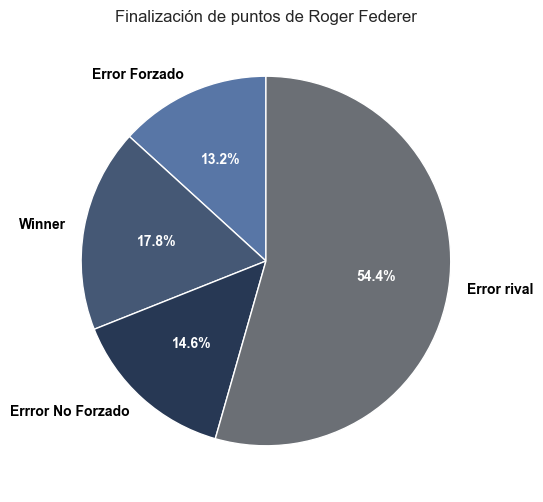

In [51]:
#pie chart of player point endings
colors=['#5876a6','#455875','#273854','#6b6f75']



# Create the pie chart with the new colors and text properties
plt.figure(figsize=(10, 6))
plt.pie(
    player_point_endings.iloc[:, 1:].values.flatten(),
    labels=player_point_endings.columns[1:],
    autopct=lambda p: f'{p:.1f}%',  # Add labels with percentage values
    startangle=90,
    colors=colors,
    textprops={'color': 'black', 'weight': 'bold'}
)

# Update the percentage text properties to white
for text in plt.gca().texts:
    if '%' in text.get_text():
        text.set_color('white')

plt.title(f'Finalización de puntos de {jugador_elegido}')
plt.savefig('viz_outputs/finalizacion_puntos.png', facecolor='white', bbox_inches='tight')
plt.show()

## Golpes y direccion

In [14]:
def count_numbers(column):
    counts = {'1': 0, '2': 0, '3': 0}
    for entry in column:
        counts['1'] += len(re.findall(r'1', entry))
        counts['2'] += len(re.findall(r'2', entry))
        counts['3'] += len(re.findall(r'3', entry))
    return counts

In [15]:
counts = pd.Series(count_numbers(df_player['Sequence'])).reset_index().sort_values(by='index')
direcciones_dict = {"1": 'derecha', "2": 'centro', "3": 'izquierda'}
counts['index'] = counts['index'].map(direcciones_dict)
counts = counts.rename(columns={'index': 'direccion', 0: 'count'})

counts['count_pct'] = round(counts['count'] / counts['count'].sum() * 100, 2)

counts

,direccion,count,count_pct
0,derecha,48163,28.31
1,centro,54740,32.17
2,izquierda,67238,39.52


In [16]:
def count_serves(column):
    counts_serves = {'4': 0, '5': 0, '6': 0}
    for entry in column:
        counts_serves['4'] += len(re.findall(r'4', entry))
        counts_serves['5'] += len(re.findall(r'5', entry))
        counts_serves['6'] += len(re.findall(r'6', entry))
    return counts_serves

counts_serves = pd.Series(count_serves(df_player['Sequence'])).reset_index().sort_values(by='index')
direcciones_dict = {"4": 'ancho', "5": 'cuerpo', "6": 'A la "T"'}
counts_serves['index'] = counts_serves['index'].map(direcciones_dict)
counts_serves = counts_serves.rename(columns={'index': 'direccion', 0: 'count'})

counts_serves['count_pct'] = round(counts_serves['count'] / counts_serves['count'].sum() * 100, 2)
counts_serves

,direccion,count,count_pct
0,ancho,30118,47.75
1,cuerpo,8345,13.23
2,"A la ""T""",24608,39.02


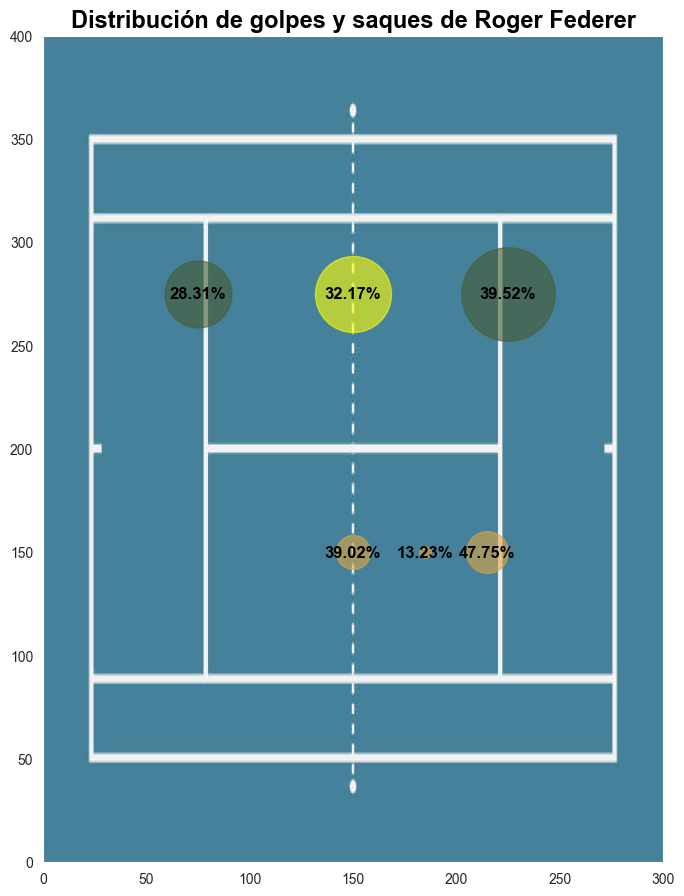

In [17]:
import matplotlib.pyplot as plt

# Cargar la imagen de la cancha
court_image = plt.imread('cancha_imagen.jpg')

# Coordenadas y colores
points = {
    "derecha": (75, 275),
    "centro": (150, 275),
    "izquierda": (225, 275),
}

serve_points = {
    "ancho": (215, 150),
    "cuerpo": (185, 150),
    'A la "T"': (150, 150),
}

colors = {
    "derecha": '#455c31',
    "centro": 'yellow',
    "izquierda": '#455c31',
}

# Crear la figura
fig, ax = plt.subplots(figsize=(8, 12))
ax.imshow(court_image, extent=[0, 300, 0, 400])

ax.grid(False)

# Iterar sobre los datos y plotear los puntos
for direccion, count, count_pct in zip(counts["direccion"], counts["count"], counts["count_pct"]):
    x, y = points[direccion]  # Coordenadas del punto
    ax.scatter(x, y, s=(count / 1000) ** 2, color=colors[direccion], alpha=0.6, label=direccion)  # Ajuste exagerado
    # bold annotation
    ax.text(x, y, f"{count_pct:.2f}%", color='black', fontsize=12, ha='center', va='center', weight='bold')
    # Anotación con porcentaje
    
for direccion, count, count_pct in zip(counts_serves["direccion"], counts_serves["count"], counts_serves["count_pct"]):
    x, y = serve_points[direccion]  # Coordenadas del punto
    ax.scatter(x, y, s=(count / 1000) ** 2, color='#dea740', alpha=0.6, label=direccion)  # Ajuste exagerado
    # bold annotation
    ax.text(x, y, f"{count_pct:.2f}%", color='black', fontsize=12, ha='center', va='center', weight='bold')
    # Anotación con por

# Configuración del gráfico
ax.set_xlim(0, 300)
ax.set_ylim(0, 400)
# bigger title
plt.title(f"Distribución de golpes y saques de {jugador_elegido}", fontsize=17, weight='bold', color='black')

# Guardar y mostrar la gráfica
plt.savefig('viz_outputs/direccion_golpes_cancha.png', facecolor='white', bbox_inches='tight')
plt.show()


## Agresividad y seguridad en sus rallies

In [18]:
agresivos = df_clustered[df_clustered['cluster'] == 2].groupby('Player')[['cluster']].count().reset_index()
seguros = df_clustered[df_clustered['cluster'] == 1].groupby('Player')[['cluster']].count().reset_index()
pts_por_jugador = df_clustered.groupby('Player')[['Pt']].count().reset_index()

# merge
agresivos = agresivos.merge(pts_por_jugador, on='Player', how='left')
agresivos['ratio_agresividad'] = round(agresivos['cluster'] / agresivos['Pt'] * 100,2)

agresivos = agresivos.merge(seguros, on='Player', how='left')
agresivos['ratio_seguros'] = round(agresivos['cluster_y'] / agresivos['Pt'] * 100,2)

agresivos = agresivos.rename(columns={'cluster_x': 'agresivos', 'cluster_y': 'seguros', 'Pt': 'total_pts'})

agresivos[agresivos['Player'].isin([jugador_elegido, jugador_elegido_comparable])]

,Player,agresivos,total_pts,ratio_agresividad,seguros,ratio_seguros
569,Novak Djokovic,2119,24815,8.54,19128.0,77.08
635,Roger Federer,4747,30543,15.54,17049.0,55.82


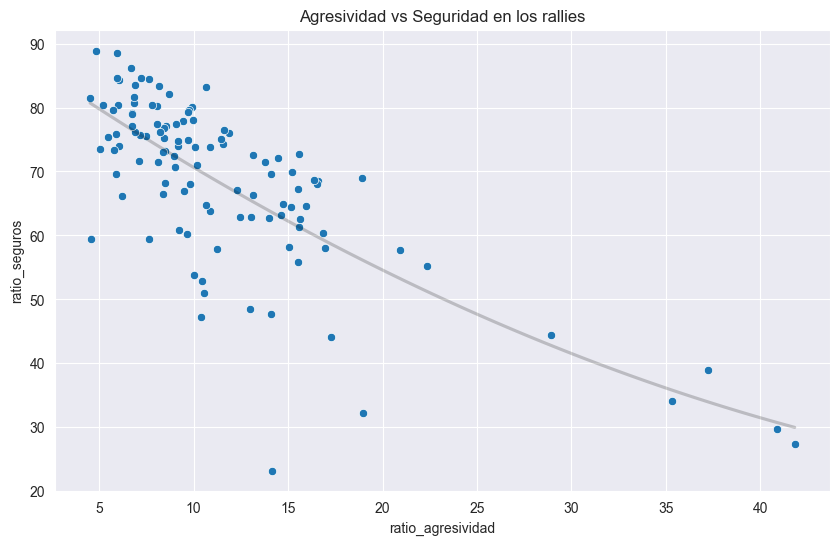

In [19]:
scatt_agresivo_seguro = agresivos[agresivos['total_pts'] > 1000].sort_values(by='ratio_agresividad', ascending=False)

#scatter plot entre agresividad y seguridad
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatt_agresivo_seguro, x='ratio_agresividad', y='ratio_seguros')
plt.title('Agresividad vs Seguridad en los rallies')
plt.xlabel('Agresividad (%)')
plt.ylabel('Seguridad (%)')
#add non linear regression line, transparent
sns.regplot(data=scatt_agresivo_seguro, x='ratio_agresividad', y='ratio_seguros', scatter=False, order=2, ci=None, color='black', line_kws={'alpha': 0.2})
plt.savefig('viz_outputs/agresividad_seguridad.png', facecolor='white', bbox_inches='tight')
plt.show()


In [20]:
scatt_agresivo_seguro

,Player,agresivos,total_pts,ratio_agresividad,seguros,ratio_seguros
677,Stefan Edberg,2577,6163,41.81,1687.0,27.37
373,John Mcenroe,681,1666,40.88,494.0,29.65
268,Goran Ivanisevic,417,1120,37.23,436.0,38.93
109,Boris Becker,1327,3755,35.34,1277.0,34.01
595,Pete Sampras,1713,5924,28.92,2631.0,44.41
...,...,...,...,...,...,...
14,Albert Ramos,60,1148,5.23,923.0,80.40
405,Karim Mohamed Maamoun,118,2327,5.07,1710.0,73.49
374,John Millman,53,1091,4.86,970.0,88.91
100,Bernard Tomic,47,1024,4.59,608.0,59.38


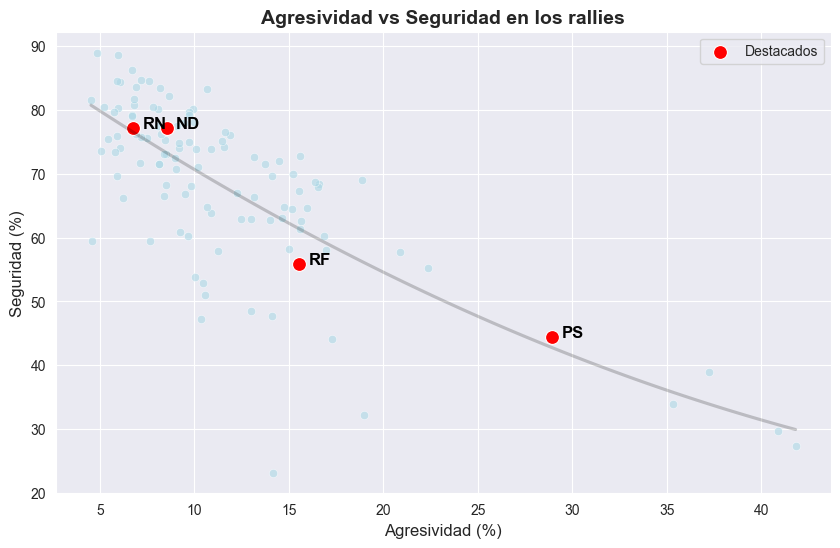

In [21]:
# Filtrar los datos de los jugadores específicos
players_to_highlight = ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Pete Sampras']
highlight_data = scatt_agresivo_seguro[scatt_agresivo_seguro['Player'].isin(players_to_highlight)]

# Crear el scatter plot base
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatt_agresivo_seguro, x='ratio_agresividad', y='ratio_seguros', alpha=0.6, color='lightblue')

# Añadir puntos destacados
sns.scatterplot(data=highlight_data, x='ratio_agresividad', y='ratio_seguros', color='red', s=100, label='Destacados')
sns.regplot(data=scatt_agresivo_seguro, x='ratio_agresividad', y='ratio_seguros', scatter=False, order=2, ci=None, color='black', line_kws={'alpha': 0.2})

# Añadir anotaciones con las iniciales (formato Nombre Apellido -> Iniciales)
for _, row in highlight_data.iterrows():
    initials = ''.join([name[0].upper() for name in row['Player'].split()])  # Generar iniciales
    plt.text(
        row['ratio_agresividad'] + 0.5,  # Ajuste horizontal
        row['ratio_seguros'],  # Ajuste vertical
        initials,  # Iniciales
        fontsize=12,
        color='black',
        weight='bold'
    )

# Títulos y etiquetas
plt.title('Agresividad vs Seguridad en los rallies', fontsize=14, weight='bold')
plt.xlabel('Agresividad (%)', fontsize=12)
plt.ylabel('Seguridad (%)', fontsize=12)
plt.legend()

plt.savefig('viz_outputs/agresividad_seguridad.png', facecolor='white', bbox_inches='tight')
# Mostrar gráfico
plt.show()


## Velocidad de saque

In [22]:
#merge speed and matches datasets, but only add the players to the speed dataset
df_speed_kmh_players = df_speed_kmh.merge(df_matches_grand_slam[['match_id', 'player1', 'player2']], left_on='match_id', right_on='match_id')

In [23]:
df_speed_kmh_players

,match_id,ElapsedTime,SetNo,P1GamesWon,P2GamesWon,SetWinner,GameNo,GameWinner,PointNumber,PointWinner,...,WinnerType,WinnerShotType,P1DistanceRun,P2DistanceRun,RallyCount,ServeWidth,ServeDepth,ReturnDepth,player1,player2
0,2011-ausopen-1101,0:00:00,1.0,0.0,0.0,0.0,1.0,0.0,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rafael Nadal,Marcos Daniel
1,2011-ausopen-1101,0:00:23,1.0,0.0,0.0,0.0,1.0,0.0,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rafael Nadal,Marcos Daniel
2,2011-ausopen-1101,0:00:59,1.0,0.0,0.0,0.0,1.0,0.0,3,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rafael Nadal,Marcos Daniel
3,2011-ausopen-1101,0:01:57,1.0,1.0,0.0,0.0,1.0,1.0,4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rafael Nadal,Marcos Daniel
4,2011-ausopen-1101,0:03:23,1.0,1.0,0.0,0.0,2.0,0.0,5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rafael Nadal,Marcos Daniel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403868,2023-wimbledon-2701,1:16:33,2.0,5.0,4.0,0.0,9.0,1.0,120,1.0,...,0,0,17.062,14.132,4.0,B,NCTL,ND,Marketa Vondrousova,Ons Jabeur
1403869,2023-wimbledon-2701,1:18:13,2.0,5.0,4.0,0.0,10.0,0.0,121,1.0,...,0,0,38.604,77.860,11.0,C,CTL,D,Marketa Vondrousova,Ons Jabeur
1403870,2023-wimbledon-2701,1:18:48,2.0,5.0,4.0,0.0,10.0,0.0,122,1.0,...,0,0,12.737,18.994,3.0,C,NCTL,ND,Marketa Vondrousova,Ons Jabeur
1403871,2023-wimbledon-2701,1:19:16,2.0,5.0,4.0,0.0,10.0,0.0,123,1.0,...,0,0,40.082,47.854,9.0,BW,CTL,ND,Marketa Vondrousova,Ons Jabeur


In [27]:
df_speed_kmh_players = df_speed_kmh_players[['player1', 'player2', 'ServeIndicator', 'Speed_KMH']]
df_speed_kmh_players_comparable = df_speed_kmh_players[['player1', 'player2', 'ServeIndicator', 'Speed_KMH']].copy()
# Si ServeIndicator = 1 y player1 = jugador_elegido, entonces es un saque de jugador_elegido
# Si ServeIndicator = 2 y player2 = jugador_elegido, entonces es un saque de jugador_elegido
#Filter only the serves of the player

df_speed_kmh_players = df_speed_kmh_players[(df_speed_kmh_players['player1'] == jugador_elegido) & (df_speed_kmh_players['ServeIndicator'] == 1) | (df_speed_kmh_players['player2'] == jugador_elegido) & (df_speed_kmh_players['ServeIndicator'] == 2)]

df_speed_kmh_players_comparable = df_speed_kmh_players_comparable[(df_speed_kmh_players_comparable['player1'] == jugador_elegido_comparable) & (df_speed_kmh_players_comparable['ServeIndicator'] == 1) | (df_speed_kmh_players_comparable['player2'] == jugador_elegido_comparable) & (df_speed_kmh_players_comparable['ServeIndicator'] == 2)]

print(f'Velocidad media de saque de {jugador_elegido_comparable}: {df_speed_kmh_players_comparable["Speed_KMH"].mean()}')


print(f'Velocidad media de saque de {jugador_elegido}: {df_speed_kmh_players["Speed_KMH"].mean()}')
print(f'Velocidad del percentil 75 de saque de {jugador_elegido}: {df_speed_kmh_players["Speed_KMH"].quantile(0.75)}')
print(f'Velocidad del percentil 25 de saque de {jugador_elegido}: {df_speed_kmh_players["Speed_KMH"].quantile(0.25)}')


Velocidad media de saque de Novak Djokovic: nan
Velocidad media de saque de Roger Federer: 174.63592963180957
Velocidad del percentil 75 de saque de Roger Federer: 191.0
Velocidad del percentil 25 de saque de Roger Federer: 159.0


## Servicios

# Demo para PoC
Se junta toda la informacion necesaria para su presentacion.

# Notas
* saque promedio en viz
* golpes inusuales
* 

In [ ]:
pd.read_csv('data_output/charting_clean.csv', low_memory=False).sample(5)

In [ ]:
# print the name of the first 10 files in every folder

for file in os.listdir('tennis_atp-master/')[-15:-10]:
    print(file)
    
for file in os.listdir('tennis_slam_pointbypoint-master/')[-15:-10]:
    print(file)
    
for file in os.listdir('tennis_MatchChartingProject-master/')[-15:-10]:
    print(file)
    
print('Etc...')

In [83]:
test_agresivos = df_exploded[df_exploded['Player'].isin(['Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Pete Sampras'])]

#groupby player
test_agresivos_gr = test_agresivos.groupby('Player')

#return mean point length for each player
test_agresivos_gr['Sequence'].apply(lambda x: x.apply(lambda y: len(y.split())).mean())

Player
Novak Djokovic    2.621601
Pete Sampras      1.806669
Rafael Nadal      2.590594
Roger Federer     2.191400
Name: Sequence, dtype: float64